# Salinity in the Gulf of Guinea: Lesson 1

## _Reading satellite data contained in a scientific file format._

## Objective(s).

The student will learn (1) how scientific data are stored, (2) to use Python 3 to display metadata, (3) to read a netcdf file, and (4) to display this data as a function of latitude and longitude. Some additional information specific to this satellite measurement is presented at the end.

## Description.

This script reads in a netcdf file and plots the data.

The file has been downloaded from Remote Sensing Systems (http://www.remss.com/) and contains sea surface salinity (SSS), as well as a few other data products. Below, we look at SSS and the fraction of pixels contaminated by land, zooming into a region known as the Gulf of Guinea. We then plot this as a function of geographic location. Another script (__[Lesson 2](Salinity_GulfOfGuinea_Lesson2.ipynb)__) will make an animation of these data in time.

Christian Buckingham & Eben Nyadjro

<div class="alert alert-block alert-success">
<b>_Main question_:</b> **What controls sea surface salinity in the Gulf of Guinea?** We will not answer this question completely but it is worth keeping this in the back of your mind as we work. Here, our emphasis will be on obtaining and reading data.
</div>

## Load a few important packages.

First, we load a few important packages. If you do not have these, and if you are using anaconda as your python distribution, type **`conda install xarray`** at the terminal window (MacOS, Linux) or command line (Windows). The conda manager package should download it from the internet. If you have installed python a different way, try **`pip install xarray`**.

In [1]:
## A few necessary packages.
import numpy as np
from netCDF4 import Dataset #Dataset, MFDataset
import xarray as xr
import matplotlib.pyplot as plt
import datetime as dt
import scipy.signal as signal

/anaconda3/lib/python3.6/site-packages/distributed/utils.py:128: RuntimeWarning: Couldn't detect a suitable IP address for reaching '8.8.8.8', defaulting to '127.0.0.1': [Errno 51] Network is unreachable
  % (host, default, e), RuntimeWarning)


## Read in the data from the netcdf file.

NetCDF (.nc) is a binary data format that contains not only data but information that describes the data. We refer to this latter type of information as **metadata**.

Below, we use strings to tell Python where to find the file, we display to the screen some of the metadata, and in the final portion, we plot the data itself. Let's first see what the metadata looks like.

<div class="alert alert-block alert-info">
<b>Tip:</b> In addition to metadata, sometimes the netcdf file contains **data provenance**. This is a very fancy word to say "an ability to track where the data came from and what processing steps were done on it." It is not important for this project, but it will make you sound impressive if you talk with other people.
</div>

In [2]:
# We use the xarray package to display the contents of the netcdf file.

# The reason for using the statement "decode_times=False" is that the
# xarray code naturally wants to interpret the time vector. Sometimes this
# prevents the code from working on a netcdf file that is not CF-compliant.
# That is, sometimes it doesn't have the correct standards. So to be general
# for any netcdf file, we place in the switch "decode_times=False".

# Define the filename.
pname = "/Users/ceb1c13/Dropbox/Data/2019-08-01-SMAP/" # remember the slash on the end of the pathname
fname = "RSS_smap_SSS_L3_8day_running_40km_2015_090_FNL_v03.0.nc"
infile = pname+fname

# Read the metadata of the file. This is equivalent to an "ncdump -h RSS_smap.nc" command at the terminal
# window or command line.
test = xr.open_dataset(infile,decode_times=False)
print(test.info())

xarray.Dataset {
dimensions:
	lat = 720 ;
	lon = 1440 ;
	time = 1 ;

variables:
	float32 lon(lon) ;
		lon:standard_name = longitude ;
		lon:axis = X ;
		lon:long_name = center longitude of grid cell ;
		lon:units = degrees_east ;
		lon:valid_min = 0.0 ;
		lon:valid_max = 360.0 ;
	float32 lat(lat) ;
		lat:standard_name = latitude ;
		lat:axis = Y ;
		lat:long_name = center latitude of grid cell ;
		lat:units = degrees_north ;
		lat:valid_min = -90.0 ;
		lat:valid_max = 90.0 ;
	float64 time(time) ;
		time:standard_name = time ;
		time:axis = T ;
		time:long_name = reference time of analyzed variable field corresponding to center of the product time interval ;
		time:units = seconds since 2000-01-01T00:00:00Z ;
		time:calendar = standard ;
	float64 nobs(lat, lon) ;
		nobs:long_name = Number of observations for L3 average ;
		nobs:units = 1 ;
		nobs:valid_min = 0 ;
	float32 sss_smap(lat, lon) ;
		sss_smap:long_name = SMAP sea surface salinity ;
		sss_smap:standard_name = sea_surface_salini

Now, we read in the netcdf file. This uses a function called **`Dataset`** in the **`netCDF4`** package.

In [3]:
# Read in the data from the netcdf file.
# We use the netCDF4 package to read the netcdf file.
nc = Dataset(infile, "r")
etime = nc.variables["time"][:] # time in seconds since 2000/01/00 00:00
lat = nc.variables["lat"][:] # latitude (degrees), values = [-90, 90]
lon = nc.variables["lon"][:] # longitude (degrees), values = [0, 360]
nobs = nc.variables["nobs"][:] # Number of observations for L3 average (unitless)
sss_smap = nc.variables["sss_smap"][:] # sea_surface_salinity (practical salinity units == unitless)
sss_ref = nc.variables["sss_ref"][:] # Reference sea surface salinity from HYCOM (practical salinity units == unitless)
gland = nc.variables["gland"][:] # average land fraction (weighted by antenna gain)
sst_ref = nc.variables["surtep"][:] # Ancillary sea surface temperature (from Canada Meteorological Center), doi: 10.5067/GHCMC-4FM03

# Access the "data" portion of the variable, as python handles this as a masked array.
etime = etime.data
lat = lat.data
lon = lon.data
sss = sss_smap.data
sss_hycom = sss_ref.data
sst_cmc = sst_ref.data
land_fraction = gland.data

# Collapse data to one dimension.
#etime = np.squeeze(etime)
#lat = np.squeeze(lat)
#lon = np.squeeze(lon)

# Print some info about the variables.
print(etime.dtype) # print the data type
print(etime.shape) # print the shape
print(lat.dtype) # print the data type
print(lat.shape) # print the shape
print(lon.dtype) # print the data type
print(lon.shape) # print the shape
print(sss.dtype) # print the data type
print(sss.shape) # print the shape
print(sss_hycom.dtype) # print the data type
print(sss_hycom.shape) # print the shape


float64
(1,)
float32
(720,)
float32
(1440,)
float32
(720, 1440)
float32
(720, 1440)


In [4]:
# Convert some variables to double precision (float64).
lat = np.double(lat)
lon = np.double(lon)
sss = np.double(sss)

nlat = len(lat)
nlon = len(lon)
sdata = sss.shape

In [5]:
# Handle time.

# This is really more tricky that it seems.
# Keeping track of time and converting between time units is one of the
# most tricky things in python (and in most computer languages). Thus,
# for now, we will simple convert to years since the reference time.

# Simple manner of handling time.
dtime = etime/86400 # convert seconds to days since ...
ytime = dtime/366 # convert from days to years

Now that we have the data, plot it as a global map. (This takes a few minutes because of the density of data points.)

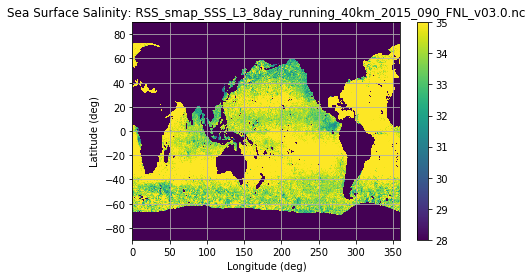

In [6]:
# Plot the salinity.
plt.pcolor(lon,lat,sss)
plt.clim(28,35)
plt.xlabel('Longitude (deg)')
plt.ylabel('Latitude (deg)')
plt.title('Sea Surface Salinity: '+fname) # here we need to insert a date inside the brackets
plt.grid()
plt.colorbar()
plt.show()

We now want to subset the global map. We examine a region centred on the Gulf of Guinea (GoG). The challenge with this particular location is that the data is given to us from the prime meridian (longitude = 0 degrees) to 360 degrees. That is, the region of the GoG falls on the *_seam_* of the data. To handle this, we add two halves of data (below, referred to as *blocks*) to a single matrix, creating one large matrix. The latitudes are the same for both *blocks*.

In [7]:
# This part is tricky because we need to obtain data across the seam.
# The smart way would be to circularly-shift the data in the column (longitude)
# direction. But as I don't know how to do this ... We just paste the two
# blocks in a larger matrix.

# Subset for the region of interest.
latlim = np.array([-10.0,10.0])
lonlim = np.array([-20.0,15.0])
latlim = np.double(latlim)
lonlim = np.double(lonlim)
ilat1 = (lat >= latlim[0]) & (lat <= latlim[1])
ilon1 = ((lon-360.0) >= lonlim[0]) & ((lon-360.0) < 0.);
ilon2 = (lon >= 0) & (lon <= lonlim[1])
ilat = ilat1;
ilon = np.concatenate((ilon1,ilon2), axis=0)

lats = lat[ilat1]
lons1 = lon[ilon1] - 360
lons2 = lon[ilon2]
lons = np.concatenate((lons1,lons2), axis=0)

index1 = np.array(np.where(ilat))
index2 = np.array(np.where(ilon))
#print(index1)
#print(index2)
sss_block1 = sss[ilat,:]
sss_block1 = sss_block1[:,ilon1]
sss_block2 = sss[ilat,:]
sss_block2 = sss_block2[:,ilon2]

nlats = len(lats)
nlons = len(lons)
nlons1 = len(lons1)
nlons2 = len(lons2)
sss_block = np.zeros([nlats,nlons])
sss_block[0:nlats,0:nlons1] = sss_block1
sss_block[0:nlats,nlons1:nlons1+nlons2] = sss_block2

# Form a mask for the land.
# This mask uses the bad salinity values to identify land.
mask = np.zeros([nlats,nlons])
igood = (sss_block >= 10) # find good salinity values
mask[igood] = 1
inan = (sss_block < 10) # find bad values
mask[inan] = np.nan # not a number

We will now plot the sea surface salinity for a single day. Fresh water (low salinity) is depicted as dark blue. Note, **there seems to be a lot of fresh water emanating from the coastline and which is likely due to the Congo and Niger rivers.** Also note, we are multiplying by the mask (nans where data is bad, ones where it is good) to distinguish between bad measurements and good measurements. It also shows land as white, which is helpful.

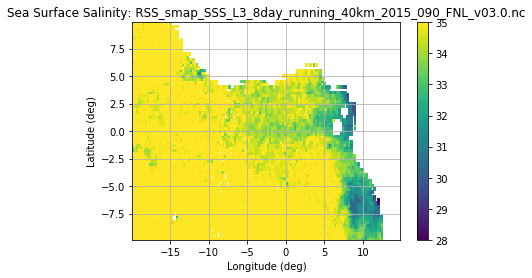

In [8]:
# Plot the salinity.
plt.pcolor(lons,lats,sss_block*mask)
plt.clim(28,35)
plt.xlabel('Longitude (deg)')
plt.ylabel('Latitude (deg)')
plt.title('Sea Surface Salinity: '+fname) # here we need to insert a date inside the brackets
plt.grid()
plt.colorbar()
plt.show()

The following plot examines how the salinity values are contaminated by radiation from the land. This happens for microwave-derived salinity measurements because it is a passive sensor, and the radiation from satellite TV antennas and other technology tend to bias the results. So, whoever created the netcdf file was aware of this problem and masked out values of salinity for which the `gland` variable had a value exceeding a given amount.

To be honest, I don't understand the units of this variable but it seems to have been multiplied by the antennae gain. For right now, just simply look at the colours, where bright (yellow) colours indicate bias in the salinity measurements.

In [9]:
# Look at the fraction of pixels contaminated by land.
land_block1 = land_fraction[ilat,:]
land_block1 = land_block1[:,ilon1]

land_block2 = land_fraction[ilat,:]
land_block2 = land_block2[:,ilon2]

land_block = np.zeros([nlats,nlons]) # allocate space
land_block[0:nlats,0:nlons1] = land_block1
land_block[0:nlats,nlons1:nlons1+nlons2] = land_block2

# Land fraction threshold (in metadata).
land_fraction_threshold = 0.00800000037997961
iland = land_block > land_fraction_threshold # pixels that are land
#mask = np.ones([nlats,nlons])
#mask[iland] = np.nan # not a number

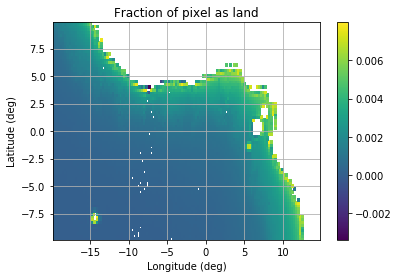

In [10]:
# Plot the land fraction.
plt.pcolor(lons,lats,(land_block*mask))
#plt.clim(0,1)
plt.xlabel('Longitude (deg)')
plt.ylabel('Latitude (deg)')
plt.title('Fraction of pixel as land')
plt.grid()
plt.colorbar()
plt.show()